In this notebook, we will cover the following topics: 

1. Implementing kernel regression from scratch using the Laplace kernel. 
2. Showcasing the effect of tuning the bandwidth parameter during kernel regression. 
3. Incorporating good kernels (e.g. Laplace kernel) into a standard library such as sklearn.  

## 1. Implementing Kernel Regression from Scratch

As usual we begin by sampling some toy data.  This time, we will sample data according to the function $f(x) = \sin(10x)$.  

In [1]:
import numpy as np

# Don't forget to set your random seeds so that experiments are all reproducible
SEED = 1717
np.random.seed(SEED)

def sample_data(num_samples):
    X = np.random.uniform(size=(num_samples, 1))
    y = np.sin(10 * X)
    return X, y

n_train, n_test = 30, 1000
X_train, y_train = sample_data(n_train)
X_test, y_test = sample_data(n_test)

# I will be sorting X_test, y_test so that I can easily visualize the test data as a curve
X_test, y_test = zip(*sorted(zip(X_test, y_test), key=lambda x: x[0][0]))
X_test = np.array(X_test)
y_test = np.array(y_test)

As is good practice, we will visualize the data to see what it looks like.

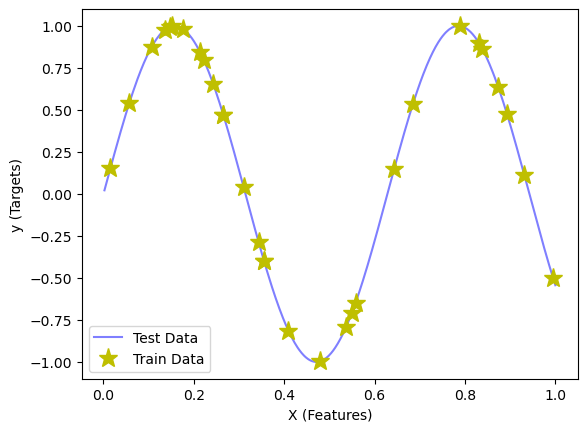

In [2]:
import matplotlib.pyplot as plt

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=14, label='Train Data')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

We then implement the Laplace kernel in a naive fashion using for loops below.

In [3]:
from numpy.linalg import norm 

# Some code for non-vectorized Laplace kernel 
def laplace_naive(x, z, L=10):
    return np.exp(-norm(x - z) / L)

Next, we will use the kernel and training data above to solve kernel regression and visualize the corresponding solution.  Recall that solving kernel regression involves two steps:

1. Build the kernel matrix $K = K(X, X) \in \mathbb{R}^{n \times n}$.
2. Solve the linear system of equations $\alpha K = y$.

In [4]:
from numpy.linalg import solve 
import time 

start = time.time()
# Step 1: Build K(X_train, X_train)
L = 10  # Select a bandwidth for Laplace kernel (10 is usually a good choice)
K = np.zeros((n_train, n_train))
for i in range(n_train):
    for j in range(n_train):
        K[i, j] = laplace_naive(X_train[i], X_train[j], L=L)
        
# Step 2: Solve a linear system of equations corresponding to alpha K = y
alpha = solve(K, y_train)  # Note the shape of alpha is n_train x 1
end = time.time()
print("Total training time: ", end - start)

Total training time:  0.015385866165161133


So now we have just solved kernel regression.  Notice again that this was very few lines of code.  Let us see how our predictor performs on test data now.  Recall that unlike linear regression, we need to transform our test data to the right space before multiplying by $\alpha$ above.  Namely for prediction, we need to follow these steps:

1. $k = K(X, x)$
2. $f(x) = \alpha k$.

In [5]:
from sklearn.metrics import r2_score

start = time.time()
# Step 1: Build k = K(X, x)
k = np.zeros((n_test, n_train))
for i in range(n_test):
    for j in range(n_train):
        k[i, j] = laplace_naive(X_test[i], X_train[j], L=L)

# Step 2: Compute f(x) = alpha k 
test_pred = k @ alpha 
end = time.time()
print("Total prediction time: ", end - start)

Total prediction time:  0.14540386199951172


Test R2 Score:  0.9975096029760911


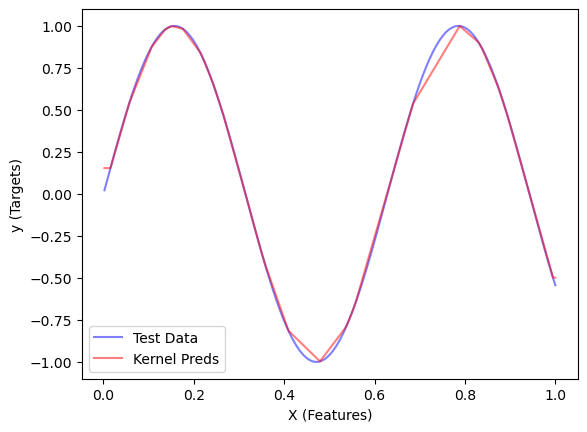

In [6]:
# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

For the example above, we see that the Laplace kernel gives terrific performance, and this is corroborated by the fact that the $R^2$ is almost $1$.  However, we have unfortunately written the above code using for loops and this will slow things down drastically.  Below, we share an implementation of Laplace kernel that is vectorized, i.e. we remove the for loops and use matrix and vector computations available in NumPy.  

Vectorization is a tremendously useful tool in practice and is a driving force behind drastic speed ups in machine learning models.  It may be worth your while to walk through the operations below slowly and try implementing them yourself to understand how vectorization works.  

In [7]:
def euclidean_distances(samples, centers, squared=True):
    samples_norm = np.sum(samples**2, axis=1, keepdims=True)
    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = np.sum(centers**2, axis=1, keepdims=True)
    centers_norm = np.reshape(centers_norm, (1, -1))
    distances = samples @ centers.T
    distances *= -2
    distances = distances + samples_norm + centers_norm
    if not squared:
        distances = np.where(distances < 0, 0, distances)
        distances = np.sqrt(distances)

    return distances

def laplacian(samples, centers, bandwidth):
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers, squared=False)
    kernel_mat = np.where(kernel_mat < 0, 0, kernel_mat)
    gamma = 1. / bandwidth
    kernel_mat *= -gamma
    kernel_mat = np.exp(kernel_mat)
    return kernel_mat

class LaplaceKernel():

    def __init__(self, L=10):
        self.sol = None
        self.L = L
        self.X_train = None

    def fit(self, X, y, reg=0):
        self.X_train = X
        K = laplacian(X, X, self.L)
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        K = laplacian(self.X_train, X, self.L)
        return (self.sol @ K).T

We will now redo the example above using the ```LaplaceKernel``` class defined above.  

In [8]:
model = LaplaceKernel()
start = time.time()
model.fit(X_train, y_train)
end = time.time()
training_time = end - start

start = time.time()
test_pred = model.predict(X_test)
end = time.time()
prediction_time = end - start

print("Total training time: ", end - start, " Total prediction time: ", end - start)

Total training time:  0.003631114959716797  Total prediction time:  0.003631114959716797


Test R2 Score:  0.997509602976091


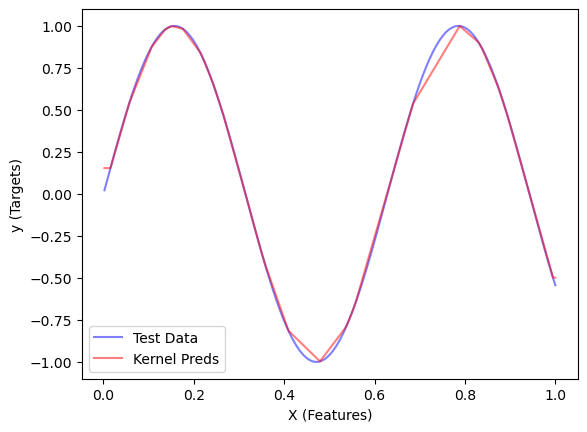

In [9]:
# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

Comparing the vectorized code above to the for loop implementation, notice that the training and prediction times of the vectorized code are orders of magnitude smaller than that of the for loop code (prediction time without vectorization is ~.1 and .002 with vectorization for example).  

## 2. The Effect of Bandwidth and Ridge Regularization

We will now illustrate the effect of changing the bandwidth parameter $L$ and ridge regularization can affect performance of kernel machines.  Let us consider how well Laplace kernel performs on the same data as above but assuming now that the training data has some noise.

In [10]:
def sample_noisy_data(n_samples, add_noise=False):
    X = np.random.uniform(size=(n_samples, 1))
    if add_noise:
        noise = np.random.normal(size=(n_samples, 1)) * .5
        y = np.sin(10 * X) + noise
    else:
        y = np.sin(10 * X)
    return X, y    
    
n_train = 30
n_test = 1000
X_train, y_train = sample_noisy_data(n_train, add_noise=True)
X_test, y_test = sample_noisy_data(n_test)

# I will be sorting X_test, y_test so that I can easily visualize the test data as a curve
X_test, y_test = zip(*sorted(zip(X_test, y_test), key=lambda x: x[0][0]))
X_test = np.array(X_test)
y_test = np.array(y_test)

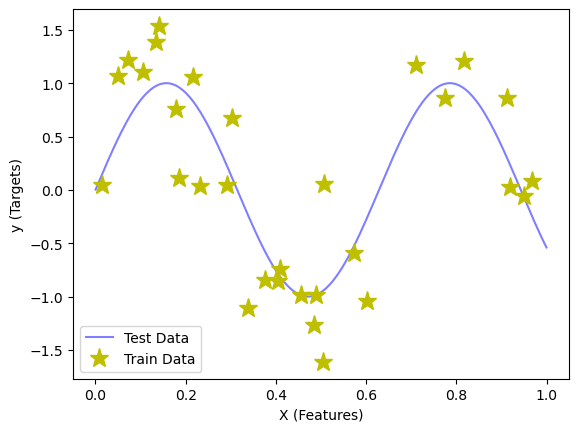

In [11]:
import matplotlib.pyplot as plt

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=14, label='Train Data')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

Note above that due to noise in the training data, some training samples (stars) are far from the blue curve.  If we interpolate (or solve kernel regression exactly), then our predictor will learn a function that jumps to these points.  This will cause our predictor to be far from the blue curve at these points, which can reduce performance.  

Test R2 Score:  0.6831836442038175


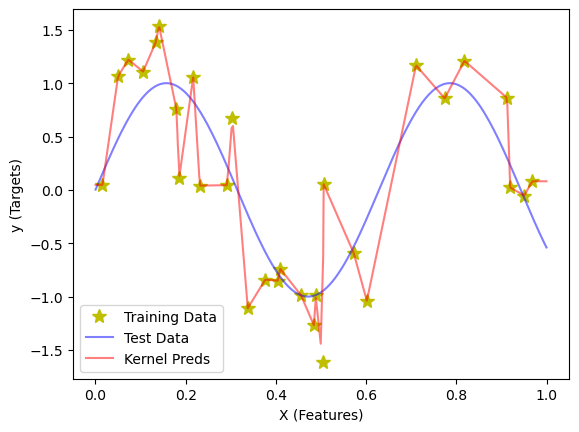

In [12]:
model = LaplaceKernel()
model.fit(X_train, y_train)
test_pred = model.predict(X_test)

# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=10, label='Training Data')
plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

To mitigate the effect of noise in the above data, we will resort to using ridge regularization.  In particular, ridge regression involves simply adding a constant (the regularization parameter) times the identity matrix during the solve function. In particular, we solve kernel ridge regression with ridge parameter $\lambda \geq 0$ as follows:

1.  $K = K(X, X)$
2.  $\alpha = y (K + \lambda I)^{-1}$

We have implemented ridge regression in our LaplaceKernel class already and showcase how performance varies when using $\lambda = 10^{-2}$ below for this problem.  In practice, we typically will grid search over multiple values of $\lambda$ and find the one that gives best performance on a validation set.  

Test R2 Score:  0.8831530532586374


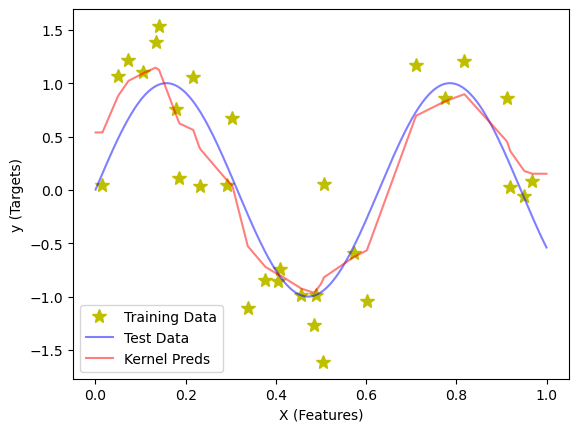

In [13]:
model = LaplaceKernel()
model.fit(X_train, y_train, reg=1e-2)
test_pred = model.predict(X_test)

# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=10, label='Training Data')
plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

We can see that ridge regularization results in our learned predictor no longer fitting training data exactly.  In this specific case, such regularization is advantageous and leads to a sizable boost in $R^2$.  

#### Important:  While in the example above, interpolation can lead to worse results due to the effect of noise, this can change in higher dimensions.  Indeed, there are many datasets for which perfectly fitting data leads to best results.  Thus, it is best practice to often try interpolating the data and thinking of ridge regularization as a trick for fine-tuning the model to get slightly improved performance.  

Another hyperparameter that can be tuned for kernel regression with the Laplace kernel is the bandwidth parameter $L$.  Recall that the Laplace kernel is given as:

$K(x, z) = \exp\left(- \frac{\|x - z\|_2}{L} \right).$

In all the examples above, we chose $L = 10$.  Let us now consider how changing the value of $L$ impacts the learned predictor. 

#### Case 1:  $L \to 0$.  

When $L$ approaches $0$, note that $K(x, x) = 1$ and $K(x, z) \to 0$ if $x \neq z$. Hence, the training kernel matrix is the identity matrix and so the solution to kernel regression is given by: 

$f(x) = y K(X, X)^{-1} K(X, x) = y K(X, x)$.  

Now if $x$ is not a training sample, then $K(X, x) = \mathbf{0}$.  Hence, as $L \to 0$, we can always fit training data, but the prediction at test points approaches $0$.  

Test R2 Score:  0.035708092194696395


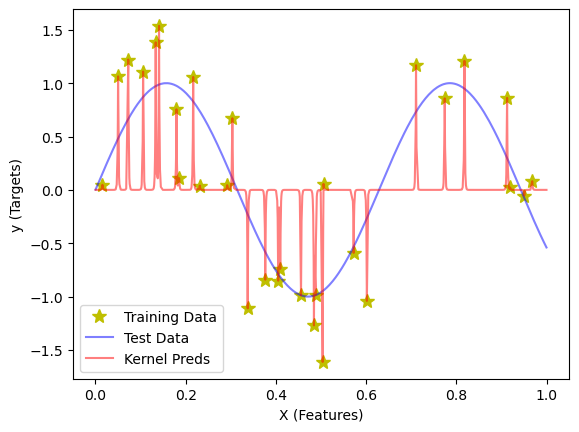

In [14]:
model = LaplaceKernel(L=.001)
model.fit(X_train, y_train)

X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)
X_all, y_all = zip(*sorted(zip(X_all, y_all), key=lambda x: x[0][0]))
X_all = np.array(X_all)
y_all = np.array(y_all)

test_pred = model.predict(X_test)
all_pred = model.predict(X_all)

# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=10, label='Training Data')
plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_all.reshape(-1), all_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

#### Case 2:  $L \to \infty$ and we use ridge regularization $\lambda > 0$.  

When $L$ approaches $\infty$, note that $K(x, z) \to 1$ for all $x, z$. Hence, the training kernel matrix is given by the all ones matrix, which we denote as $J$.  Note that the all ones matrix is not invertible.  Thus, we would resort to using the pseudoinverse or we can add ridge regularization.  We will consider the latter case below.  In particular, the solution to kernel regression is now given by: 

$f(x) = y [K(X, X) + \lambda I]^{-1} K(X, x) = y [J + \lambda I]^{-1} \mathbf{1}$.  

We can write the inverse of $J + \lambda I$ using the [Sherman-Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula). 

In particular, we will find that the solution is given by: 

$f(x) = C \sum_{i=1}^{n} y_i , $

where $C = \left(\frac{1}{\lambda} - \frac{n}{\lambda^2 + \lambda n} \right).$

Test R2 Score:  -0.006329917625355286


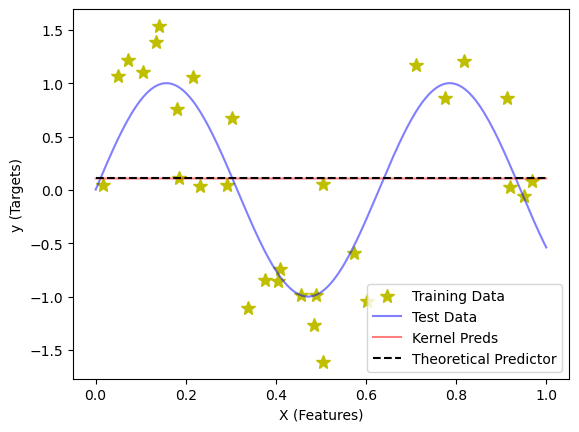

In [15]:
model = LaplaceKernel(L=100000)
l = .1
model.fit(X_train, y_train, reg=l)
test_pred = model.predict(X_test)

# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

# We will compute this constant using the Sherman-Morrison formula
C = np.sum(y_train) * ( 1/l - n_train / (l**2 + l*n_train))
                       
plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=10, label='Training Data')
plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.plot([0, 1], [C, C], 'k--', label='Theoretical Predictor')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

## 3.  Standard Libraries for Kernel Regression

We note that sklearn does not come with a default implementation for the Laplace kernel.  This is unfortunate as the Laplace kernel is one of the best performing kernels on a variety of datasets (e.g. see [Paper 1](https://arxiv.org/abs/2007.01580), [Paper 2](https://arxiv.org/abs/2212.13881)). 

Below, we analyze the performance of using kernels for classification.  In particular, we consider the following problem: 

$f^*(x) = \text{sign}(x_1 x_2 x_3)$ for $x \in \mathbb{R}^{3}$. 


In [19]:
d = 3
def high_dim_data(n_samples):
    X = np.random.normal(size=(n_samples, d))
    prod = 1.
    for i in range(d):
        prod *= X[:, i]
    y = np.where(prod > 0, 1, -1)
    return X, y    

def get_acc(y_pred, y_true):
    y_pred = np.where(y_pred > 0, 1, -1)
    return np.mean(y_pred == y_true)

In [32]:
n_train = 3000
n_test = 10000
X_train, y_train = high_dim_data(n_train)
X_test, y_test = high_dim_data(n_test)

In [33]:
from sklearn.kernel_ridge import KernelRidge

L = 10
start = time.time()
K_train = laplacian(X_train, X_train, L)
K_test = laplacian(X_test, X_train, L)
reg = 0
model = KernelRidge(kernel='precomputed', alpha=reg)
model.fit(K_train, y_train)
test_pred = model.predict(K_test)
end = time.time()
print("Total Time: ", end - start)

acc = get_acc(test_pred, y_test)
print("Test Acc: ", acc)

Total Time:  0.870560884475708
Test Acc:  0.9507


In [34]:
model = LaplaceKernel(L=10)
l = 0
start = time.time()
model.fit(X_train, y_train, reg=l)
test_pred = model.predict(X_test)
end = time.time()

print("Total time: ", end - start)

acc = get_acc(test_pred, y_test)
print("Test Acc: ", acc)

Total time:  0.8875236511230469
Test Acc:  0.9507
